# Evolución de imágenes (EA) — Objetivo: replicar una imagen objetivo

Este notebook muestra paso a paso un **algoritmo evolutivo** que intenta reconstruir una imagen objetivo partiendo de una población aleatoria de 50 imágenes RGB (tamaño 120×180, valores 0–255).

**Configuración**:

- Población: 50 individuos.
- Tamaño imagen: 120×180 píxeles, 3 canales (RGB).
- Aptitud (fitness): similaridad a la imagen objetivo medida por MSE (mean squared error). Se busca minimizar el MSE.
- Operadores: torneo (selección), crossover uniforme por píxel, mutación aditiva en píxeles aleatorios.

El notebook contiene código ejecutable dividido en bloques: definición de funciones, inicialización, evaluación, bucle evolutivo, visualizaciones y parámetros para experimentar.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

IMG_H, IMG_W = 120, 180
POP_SIZE = 50

# Funciones auxiliares
def make_random_image(h=IMG_H, w=IMG_W, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.integers(0,256, size=(h,w,3), dtype=np.uint8)

def show_image(ax, img, title=None):
    ax.imshow(img.astype(np.uint8))
    ax.axis('off')
    if title is not None:
        ax.set_title(title, fontsize=10)

def initialize_population(pop_size=POP_SIZE, h=IMG_H, w=IMG_W, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.integers(0,256, size=(pop_size,h,w,3), dtype=np.uint8)

def mse_batch(pop, target):
    diff = pop.astype(np.int32) - target.astype(np.int32)
    mse = np.mean(diff*diff, axis=(1,2,3))
    return mse


## Operadores evolutivos
Definición de selección por torneo, crossover uniforme y mutación aditiva por píxel.

In [ ]:
# Operadores y bucle evolutivo
def tournament_select(pop, mse, k=3, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    idxs = rng.integers(0, N, size=(N, k))
    selected = []
    for row in idxs:
        best = row[np.argmin(mse[row])]
        selected.append(best)
    return np.array(selected, dtype=int)

def uniform_crossover(parent_a, parent_b, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mask = rng.random(parent_a.shape) < 0.5
    child = np.where(mask, parent_a, parent_b).astype(np.uint8)
    return child

def mutate_image(img, mutation_prob_pixel=1e-3, mutation_std=15, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    img = img.astype(np.int32)
    mask = rng.random(img.shape) < mutation_prob_pixel
    if not mask.any():
        return img.astype(np.uint8)
    noise = rng.normal(loc=0.0, scale=mutation_std, size=img.shape).astype(np.int32)
    img[mask] += noise[mask]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def evolve(pop, target, max_gens=500, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    history = []
    mse = mse_batch(pop, target)
    best_idx = int(np.argmin(mse))
    history.append(mse[best_idx])
    for gen in range(1, max_gens+1):
        sel_idxs = tournament_select(pop, mse, k=3, rng=rng)
        parents = pop[sel_idxs]
        offspring = np.empty_like(parents)
        for i in range(0, N, 2):
            a = parents[i]
            b = parents[i+1 if i+1<N else 0]
            if rng.random() < 0.9:
                child1 = uniform_crossover(a, b, rng=rng)
                child2 = uniform_crossover(b, a, rng=rng)
            else:
                child1 = a.copy(); child2 = b.copy()
            child1 = mutate_image(child1, mutation_prob_pixel=1e-3, mutation_std=15, rng=rng)
            child2 = mutate_image(child2, mutation_prob_pixel=1e-3, mutation_std=15, rng=rng)
            offspring[i] = child1
            if i+1 < N:
                offspring[i+1] = child2
        pop = offspring
        mse = mse_batch(pop, target)
        best_idx = int(np.argmin(mse))
        history.append(mse[best_idx])
        if gen % 10 == 0:
            print(f'Gen {gen}: best MSE = {history[-1]:.2f}')
        if mse[best_idx] == 0:
            print('Perfect match found at generation', gen)
            break
    best_idx = int(np.argmin(mse))
    return pop, np.array(history), pop[best_idx], mse[best_idx]


## Ejecución de ejemplo
Cree un target aleatorio, inicialice la población y ejecute el bucle evolutivo. Se muestran la comparación entre target y el mejor individuo, y la curva de convergencia.

Población y target creados. Ejecutando evolución...
Gen 10: best MSE = 10592.53
Gen 20: best MSE = 10402.70
Gen 30: best MSE = 10291.36
Gen 40: best MSE = 10221.33
Gen 50: best MSE = 10160.11
Gen 60: best MSE = 10124.54
Gen 70: best MSE = 10103.58
Gen 80: best MSE = 10089.33
Gen 90: best MSE = 10077.73
Gen 100: best MSE = 10066.87
Gen 110: best MSE = 10057.83
Gen 120: best MSE = 10049.55
Gen 130: best MSE = 10041.88
Gen 140: best MSE = 10033.61
Gen 150: best MSE = 10026.17
Gen 160: best MSE = 10016.61
Gen 170: best MSE = 10007.87
Gen 180: best MSE = 9999.04
Gen 190: best MSE = 9991.47
Gen 200: best MSE = 9982.93
Gen 210: best MSE = 9974.88
Gen 220: best MSE = 9966.56
Gen 230: best MSE = 9960.51
Gen 240: best MSE = 9954.46
Gen 250: best MSE = 9945.42
Gen 260: best MSE = 9937.77
Gen 270: best MSE = 9930.30
Gen 280: best MSE = 9922.80
Gen 290: best MSE = 9913.12
Gen 300: best MSE = 9906.60


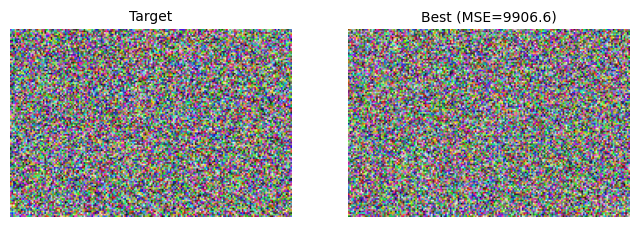

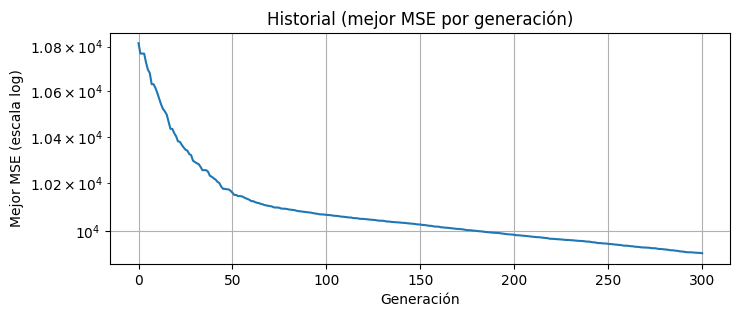

In [11]:
# Uso: crear target, inicializar población y ejecutar
rng = np.random.default_rng(42)
target = make_random_image(rng=rng)
pop = initialize_population(rng=rng)

print('Población y target creados. Ejecutando evolución...')
pop, history, best_img, best_mse = evolve(pop, target, max_gens=300, rng=rng)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(8,4))
show_image(ax[0], target, title='Target')
show_image(ax[1], best_img, title=f'Best (MSE={best_mse:.1f})')
plt.show()

plt.figure(figsize=(8,3))
plt.plot(history)
plt.yscale('log')
plt.title('Historial (mejor MSE por generación)')
plt.xlabel('Generación')
plt.ylabel('Mejor MSE (escala log)')
plt.grid(True)
plt.show()


## Añadir Elitismo al Bucle Evolutivo

### Subtask:
Modificar la función `evolve` para implementar elitismo. Esto asegurará que el mejor individuo (o un número pequeño de los mejores) de cada generación se transfiera directamente a la siguiente sin alteraciones, preservando así las mejores soluciones encontradas.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Operadores y bucle evolutivo
def tournament_select(pop, mse, k=3, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    idxs = rng.integers(0, N, size=(N, k))
    selected = []
    for row in idxs:
        best = row[np.argmin(mse[row])]
        selected.append(best)
    return np.array(selected, dtype=int)

def uniform_crossover(parent_a, parent_b, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mask = rng.random(parent_a.shape) < 0.5
    child = np.where(mask, parent_a, parent_b).astype(np.uint8)
    return child

def mutate_image(img, mutation_prob_pixel=1e-3, mutation_std=15, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    img = img.astype(np.int32)
    mask = rng.random(img.shape) < mutation_prob_pixel
    if not mask.any():
        return img.astype(np.uint8)
    noise = rng.normal(loc=0.0, scale=mutation_std, size=img.shape).astype(np.int32)
    img[mask] += noise[mask]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def evolve(pop, target, max_gens=500, n_elites=1, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    history = []
    mse = mse_batch(pop, target)
    best_idx = int(np.argmin(mse))
    history.append(mse[best_idx])

    for gen in range(1, max_gens+1):
        # 2. Identificar los individuos élite de la población actual
        elite_indices = np.argsort(mse)[:n_elites]
        elite_individuals = pop[elite_indices].copy() # Ensure a copy is made

        sel_idxs = tournament_select(pop, mse, k=3, rng=rng)
        parents = pop[sel_idxs]
        offspring = np.empty_like(parents)
        for i in range(0, N, 2):
            a = parents[i]
            b = parents[i+1 if i+1<N else 0]
            if rng.random() < 0.9:
                child1 = uniform_crossover(a, b, rng=rng)
                child2 = uniform_crossover(b, a, rng=rng)
            else:
                child1 = a.copy(); child2 = b.copy()
            child1 = mutate_image(child1, mutation_prob_pixel=1e-3, mutation_std=15, rng=rng)
            child2 = mutate_image(child2, mutation_prob_pixel=1e-3, mutation_std=15, rng=rng)
            offspring[i] = child1
            if i+1 < N:
                offspring[i+1] = child2

        # 3. Reemplazar los individuos peores en offspring con los élites
        offspring_mse = mse_batch(offspring, target)
        worst_offspring_indices = np.argsort(offspring_mse)[::-1][:n_elites]

        # Asegurarse de no reemplazar los mismos individuos si n_elites es grande
        # y N es pequeño, aunque para 1 elite esto no es un problema.
        # Esto garantiza que los élites no se pierdan.
        for i in range(n_elites):
            offspring[worst_offspring_indices[i]] = elite_individuals[i]

        pop = offspring
        mse = mse_batch(pop, target) # Recalcular MSE para la nueva población con élites

        best_idx = int(np.argmin(mse))
        history.append(mse[best_idx])
        if gen % 10 == 0:
            print(f'Gen {gen}: best MSE = {history[-1]:.2f}')
        if mse[best_idx] == 0:
            print('Perfect match found at generation', gen)
            break
    best_idx = int(np.argmin(mse))
    return pop, np.array(history), pop[best_idx], mse[best_idx]

## Cargar Imagen Objetivo desde Archivo

### Subtask:
Crear una nueva función que permita cargar la imagen objetivo desde un archivo (por ejemplo, PNG, JPG) en lugar de generarla aleatoriamente. Esto permitirá a los usuarios probar el algoritmo con imágenes específicas.


In [8]:
try:
    import PIL
except ImportError:
    print("Pillow not found, installing...")
    %pip install Pillow
    import PIL

print("Pillow is installed and imported.")

Pillow is installed and imported.


In [9]:
from PIL import Image
import numpy as np

def load_image_from_file(filepath):
    """
    Loads an image from a given filepath, converts it to RGB, and returns it as a NumPy array.
    """
    try:
        img = Image.open(filepath)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return np.array(img)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the image: {e}")
        return None

print("Function 'load_image_from_file' defined.")

Function 'load_image_from_file' defined.


## Hacer los Parámetros de Mutación Configurables

### Subtask:
Ajustar la función `mutate_image` y su invocación dentro de `evolve` para que los parámetros de mutación (`mutation_prob_pixel` y `mutation_std`) puedan ser pasados como argumentos, facilitando la experimentación con diferentes configuraciones de mutación.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Existing helper functions (assuming they are already defined or will be defined prior)
# from previous cells: make_random_image, show_image, initialize_population, mse_batch

# Operadores y bucle evolutivo
def tournament_select(pop, mse, k=3, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    idxs = rng.integers(0, N, size=(N, k))
    selected = []
    for row in idxs:
        best = row[np.argmin(mse[row])]
        selected.append(best)
    return np.array(selected, dtype=int)

def uniform_crossover(parent_a, parent_b, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mask = rng.random(parent_a.shape) < 0.5
    child = np.where(mask, parent_a, parent_b).astype(np.uint8)
    return child

def mutate_image(img, mutation_prob_pixel=1e-3, mutation_std=15, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    img = img.astype(np.int32)
    mask = rng.random(img.shape) < mutation_prob_pixel
    if not mask.any():
        return img.astype(np.uint8)
    noise = rng.normal(loc=0.0, scale=mutation_std, size=img.shape).astype(np.int32)
    img[mask] += noise[mask]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def evolve(pop, target, max_gens=500, n_elites=1, mutation_prob_pixel=1e-3, mutation_std=15, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    history = []
    mse = mse_batch(pop, target)
    best_idx = int(np.argmin(mse))
    history.append(mse[best_idx])

    for gen in range(1, max_gens+1):
        # Identificar los individuos élite de la población actual
        elite_indices = np.argsort(mse)[:n_elites]
        elite_individuals = pop[elite_indices].copy() # Ensure a copy is made

        sel_idxs = tournament_select(pop, mse, k=3, rng=rng)
        parents = pop[sel_idxs]
        offspring = np.empty_like(parents)
        for i in range(0, N, 2):
            a = parents[i]
            b = parents[i+1 if i+1<N else 0]
            if rng.random() < 0.9:
                child1 = uniform_crossover(a, b, rng=rng)
                child2 = uniform_crossover(b, a, rng=rng)
            else:
                child1 = a.copy(); child2 = b.copy()

            # Pass mutation parameters to mutate_image
            child1 = mutate_image(child1, mutation_prob_pixel=mutation_prob_pixel, mutation_std=mutation_std, rng=rng)
            child2 = mutate_image(child2, mutation_prob_pixel=mutation_prob_pixel, mutation_std=mutation_std, rng=rng)

            offspring[i] = child1
            if i+1 < N:
                offspring[i+1] = child2

        # Reemplazar los individuos peores en offspring con los élites
        offspring_mse = mse_batch(offspring, target)
        worst_offspring_indices = np.argsort(offspring_mse)[::-1][:n_elites]

        for i in range(n_elites):
            offspring[worst_offspring_indices[i]] = elite_individuals[i]

        pop = offspring
        mse = mse_batch(pop, target) # Recalcular MSE para la nueva población con élites

        best_idx = int(np.argmin(mse))
        history.append(mse[best_idx])
        if gen % 10 == 0:
            print(f'Gen {gen}: best MSE = {history[-1]:.2f}')
        if mse[best_idx] == 0:
            print('Perfect match found at generation', gen)
            break
    best_idx = int(np.argmin(mse))
    return pop, np.array(history), pop[best_idx], mse[best_idx]

print("Function 'evolve' updated with configurable mutation parameters.")

Function 'evolve' updated with configurable mutation parameters.


## Añadir Visualización Intermedia durante la Evolución

### Subtask:
Integrar código dentro de la función `evolve` para mostrar periódicamente la mejor imagen actual y su MSE. Esto proporcionará una retroalimentación visual en tiempo real sobre el progreso del algoritmo.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these helper functions are defined elsewhere or copied here for completeness.
# For the purpose of this response, I'll include them from previous cells as context.

# Helper functions from previous cells (included for completeness)
def make_random_image(h=120, w=180, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.integers(0,256, size=(h,w,3), dtype=np.uint8)

def show_image(ax, img, title=None):
    ax.imshow(img.astype(np.uint8))
    ax.axis('off')
    if title is not None:
        ax.set_title(title, fontsize=10)

def initialize_population(pop_size=50, h=120, w=180, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.integers(0,256, size=(pop_size,h,w,3), dtype=np.uint8)

def mse_batch(pop, target):
    diff = pop.astype(np.int32) - target.astype(np.int32)
    mse = np.mean(diff*diff, axis=(1,2,3))
    return mse


def tournament_select(pop, mse, k=3, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    idxs = rng.integers(0, N, size=(N, k))
    selected = []
    for row in idxs:
        best = row[np.argmin(mse[row])]
        selected.append(best)
    return np.array(selected, dtype=int)

def uniform_crossover(parent_a, parent_b, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mask = rng.random(parent_a.shape) < 0.5
    child = np.where(mask, parent_a, parent_b).astype(np.uint8)
    return child

def mutate_image(img, mutation_prob_pixel=1e-3, mutation_std=15, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    img = img.astype(np.int32)
    mask = rng.random(img.shape) < mutation_prob_pixel
    if not mask.any():
        return img.astype(np.uint8)
    noise = rng.normal(loc=0.0, scale=mutation_std, size=img.shape).astype(np.int32)
    img[mask] += noise[mask]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def evolve(pop, target, max_gens=500, n_elites=1, mutation_prob_pixel=1e-3, mutation_std=15, display_every_gen=50, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    history = []

    # Initialize best_img and best_mse outside the loop for initial display
    mse = mse_batch(pop, target)
    best_idx = int(np.argmin(mse))
    best_img_overall = pop[best_idx].copy()
    best_mse_overall = mse[best_idx]
    history.append(best_mse_overall)

    # Initial display
    if display_every_gen > 0:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        show_image(ax, best_img_overall, title=f'Gen 0: Best (MSE={best_mse_overall:.1f})')
        plt.show(block=False)
        plt.pause(0.1)

    for gen in range(1, max_gens+1):
        # Identificar los individuos élite de la población actual
        elite_indices = np.argsort(mse)[:n_elites]
        elite_individuals = pop[elite_indices].copy() # Ensure a copy is made

        sel_idxs = tournament_select(pop, mse, k=3, rng=rng)
        parents = pop[sel_idxs]
        offspring = np.empty_like(parents)
        for i in range(0, N, 2):
            a = parents[i]
            b = parents[i+1 if i+1<N else 0]
            if rng.random() < 0.9:
                child1 = uniform_crossover(a, b, rng=rng)
                child2 = uniform_crossover(b, a, rng=rng)
            else:
                child1 = a.copy(); child2 = b.copy()

            # Pass mutation parameters to mutate_image
            child1 = mutate_image(child1, mutation_prob_pixel=mutation_prob_pixel, mutation_std=mutation_std, rng=rng)
            child2 = mutate_image(child2, mutation_prob_pixel=mutation_prob_pixel, mutation_std=mutation_std, rng=rng)

            offspring[i] = child1
            if i+1 < N:
                offspring[i+1] = child2

        # Reemplazar los individuos peores en offspring con los élites
        offspring_mse = mse_batch(offspring, target)
        worst_offspring_indices = np.argsort(offspring_mse)[::-1][:n_elites]

        for i in range(n_elites):
            # Ensure there are enough offspring to replace and that the elite is not already in the worst list
            if i < len(worst_offspring_indices):
                offspring[worst_offspring_indices[i]] = elite_individuals[i]

        pop = offspring
        mse = mse_batch(pop, target) # Recalcular MSE para la nueva población con élites

        best_idx = int(np.argmin(mse))
        current_best_img = pop[best_idx].copy() # Get current best image
        current_best_mse = mse[best_idx]

        # Update overall best if current best is better
        if current_best_mse < best_mse_overall:
            best_mse_overall = current_best_mse
            best_img_overall = current_best_img

        history.append(current_best_mse)

        if gen % 10 == 0:
            print(f'Gen {gen}: best MSE = {current_best_mse:.2f}')
        if current_best_mse == 0:
            print('Perfect match found at generation', gen)
            break

        # Periodic Visualization
        if display_every_gen > 0 and (gen % display_every_gen == 0 or gen == max_gens):
            fig.clear()
            show_image(ax, current_best_img, title=f'Gen {gen}: Best (MSE={current_best_mse:.1f})')
            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.1)

    # Final display if loop finished without perfect match or if display_every_gen was 0 initially
    if display_every_gen > 0:
        plt.close(fig) # Close the interactive plot after the loop

    # Return the best image and MSE from the *final* population after all generations
    final_best_idx = int(np.argmin(mse))
    final_best_img = pop[final_best_idx]
    final_best_mse = mse[final_best_idx]

    return pop, np.array(history), final_best_img, final_best_mse

print("Function 'evolve' updated with periodic visualization.")

Function 'evolve' updated with periodic visualization.


## Refactorizar y Organizar Parámetros

### Subtask:
Centralizar todos los parámetros clave del algoritmo evolutivo (como el tamaño de la población, dimensiones de la imagen, número máximo de generaciones, probabilidad de crossover, parámetros de mutación, etc.) en un bloque de código o diccionario para facilitar su gestión y modificación.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # Ensure PIL is imported for image loading if needed later

# 1. Centralize all key evolutionary parameters into a config dictionary
config = {
    'IMG_H': 120,
    'IMG_W': 180,
    'POP_SIZE': 50,
    'MAX_GENS': 500,
    'N_ELITES': 1,
    'MUTATION_PROB_PIXEL': 1e-3,
    'MUTATION_STD': 15,
    'CROSSOVER_PROB': 0.9,
    'TOURNAMENT_K': 3,
    'DISPLAY_EVERY_GEN': 50,
}

# Helper functions
def make_random_image(h=config['IMG_H'], w=config['IMG_W'], rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.integers(0, 256, size=(h, w, 3), dtype=np.uint8)

def show_image(ax, img, title=None):
    ax.imshow(img.astype(np.uint8))
    ax.axis('off')
    if title is not None:
        ax.set_title(title, fontsize=10)

def initialize_population(pop_size=config['POP_SIZE'], h=config['IMG_H'], w=config['IMG_W'], rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.integers(0, 256, size=(pop_size, h, w, 3), dtype=np.uint8)

def mse_batch(pop, target):
    diff = pop.astype(np.int32) - target.astype(np.int32)
    mse = np.mean(diff * diff, axis=(1, 2, 3))
    return mse

# Operadores y bucle evolutivo (updated to use config)
def tournament_select(pop, mse, k=config['TOURNAMENT_K'], rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    idxs = rng.integers(0, N, size=(N, k))
    selected = []
    for row in idxs:
        best = row[np.argmin(mse[row])]
        selected.append(best)
    return np.array(selected, dtype=int)

def uniform_crossover(parent_a, parent_b, crossover_prob=config['CROSSOVER_PROB'], rng=None):
    if rng is None:
        rng = np.random.default_rng()
    if rng.random() < crossover_prob:
        mask = rng.random(parent_a.shape) < 0.5
        child = np.where(mask, parent_a, parent_b).astype(np.uint8)
        return child
    else:
        return parent_a.copy() # If no crossover, return one parent as is

def mutate_image(img, mutation_prob_pixel=config['MUTATION_PROB_PIXEL'], mutation_std=config['MUTATION_STD'], rng=None):
    if rng is None:
        rng = np.random.default_rng()
    img = img.astype(np.int32)
    mask = rng.random(img.shape) < mutation_prob_pixel
    if not mask.any():
        return img.astype(np.uint8)
    noise = rng.normal(loc=0.0, scale=mutation_std, size=img.shape).astype(np.int32)
    img[mask] += noise[mask]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def evolve(pop, target, config, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    N = pop.shape[0]
    history = []

    # Get parameters from config
    max_gens = config['MAX_GENS']
    n_elites = config['N_ELITES']
    mutation_prob_pixel = config['MUTATION_PROB_PIXEL']
    mutation_std = config['MUTATION_STD']
    crossover_prob = config['CROSSOVER_PROB']
    tournament_k = config['TOURNAMENT_K']
    display_every_gen = config['DISPLAY_EVERY_GEN']

    # Initialize best_img and best_mse outside the loop for initial display
    mse = mse_batch(pop, target)
    best_idx = int(np.argmin(mse))
    best_img_overall = pop[best_idx].copy()
    best_mse_overall = mse[best_idx]
    history.append(best_mse_overall)

    # Initial display
    if display_every_gen > 0:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        show_image(ax, best_img_overall, title=f'Gen 0: Best (MSE={best_mse_overall:.1f})')
        plt.show(block=False)
        plt.pause(0.1)

    for gen in range(1, max_gens + 1):
        # Identificar los individuos élite de la población actual
        elite_indices = np.argsort(mse)[:n_elites]
        elite_individuals = pop[elite_indices].copy()

        sel_idxs = tournament_select(pop, mse, k=tournament_k, rng=rng)
        parents = pop[sel_idxs]
        offspring = np.empty_like(parents)

        for i in range(0, N, 2):
            a = parents[i]
            b = parents[i + 1 if i + 1 < N else 0]

            child1 = uniform_crossover(a, b, crossover_prob=crossover_prob, rng=rng)
            child2 = uniform_crossover(b, a, crossover_prob=crossover_prob, rng=rng)

            child1 = mutate_image(child1, mutation_prob_pixel=mutation_prob_pixel, mutation_std=mutation_std, rng=rng)
            child2 = mutate_image(child2, mutation_prob_pixel=mutation_prob_pixel, mutation_std=mutation_std, rng=rng)

            offspring[i] = child1
            if i + 1 < N:
                offspring[i + 1] = child2

        # Reemplazar los individuos peores en offspring con los élites
        offspring_mse = mse_batch(offspring, target)
        worst_offspring_indices = np.argsort(offspring_mse)[::-1][:n_elites]

        for i in range(n_elites):
            if i < len(worst_offspring_indices):
                offspring[worst_offspring_indices[i]] = elite_individuals[i]

        pop = offspring
        mse = mse_batch(pop, target)

        best_idx = int(np.argmin(mse))
        current_best_img = pop[best_idx].copy()
        current_best_mse = mse[best_idx]

        if current_best_mse < best_mse_overall:
            best_mse_overall = current_best_mse
            best_img_overall = current_best_img

        history.append(current_best_mse)

        if gen % 10 == 0:
            print(f'Gen {gen}: best MSE = {current_best_mse:.2f}')
        if current_best_mse == 0:
            print('Perfect match found at generation', gen)
            break

        # Periodic Visualization
        if display_every_gen > 0 and (gen % display_every_gen == 0 or gen == max_gens):
            fig.clear()
            show_image(ax, current_best_img, title=f'Gen {gen}: Best (MSE={current_best_mse:.1f})')
            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.1)

    if display_every_gen > 0:
        plt.close(fig)

    final_best_idx = int(np.argmin(mse))
    final_best_img = pop[final_best_idx]
    final_best_mse = mse[final_best_idx]

    return pop, np.array(history), final_best_img, final_best_mse

print("Configuration dictionary created and all relevant functions updated to use it.")

Configuration dictionary created and all relevant functions updated to use it.
